In [1]:
# Standard library imports
import subprocess
import json
import shutil
import sys

# Contributed library imports
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from pathlib import Path

# Imports from the constants
sys.path.append("../..")
from constants import (
    get_aggregated_images_folder,
    get_aggregated_labels_folder,
    get_images_near_labels_folder,
    get_render_folder,
    get_training_data_scratch_folder,
    MMSEG_PYTHON,
    TRAIN_SCRIPT,
    MMSEG_UTILS_PYTHON,
    FOLDER_TO_CITYSCAPES_SCRIPT,
    get_work_dir,
)

# Set constants
You should be able to define most of the behavior from these constants

In [2]:
TRAINING_SITES = sorted(["chips", "delta"])

In [3]:
AGGREGATED_IMAGES_FOLDER = get_aggregated_images_folder(training_sites=TRAINING_SITES, is_ortho=False)
AGGREGATED_LABELS_FOLDER = get_aggregated_labels_folder(training_sites=TRAINING_SITES, is_ortho=False)

# We need to merge all the imagery together
# I think this should be stored in the models folder, alongside the real models
# It should be as simple as creating the folders and symlinking the existing ones into it
Path(AGGREGATED_IMAGES_FOLDER).mkdir(exist_ok=True, parents=True)
Path(AGGREGATED_LABELS_FOLDER).mkdir(exist_ok=True, parents=True)

for training_site in TRAINING_SITES:
    render_folder = get_render_folder(training_site)
    images_near_labels_folder = get_images_near_labels_folder(training_site)

    output_render_folder = Path(AGGREGATED_LABELS_FOLDER, training_site)
    output_image_folder = Path(AGGREGATED_IMAGES_FOLDER, training_site)

    # Unlink if symlink
    output_render_folder.unlink(missing_ok=True)
    output_image_folder.unlink(missing_ok=True)
    # Remove if folder
    shutil.rmtree(output_render_folder, ignore_errors=True)
    shutil.rmtree(output_image_folder, ignore_errors=True)

    shutil.copytree(render_folder, output_render_folder)
    shutil.copytree(images_near_labels_folder, output_image_folder)

In [4]:
TRAINING_DATA_FOLDER_SCRATCH = get_training_data_scratch_folder(
    training_sites=TRAINING_SITES, is_ortho=False
)

# Use one of the render folders, assuming they are all the same
IDs_to_labels_file = Path(render_folder, "IDs_to_labels.json")
with open(IDs_to_labels_file, "r") as infile:
    data = json.load(infile)

class_names = list(data.values())
class_names_str = " ".join(class_names)
print(class_names_str)

run_str = (
    f"{MMSEG_UTILS_PYTHON} {FOLDER_TO_CITYSCAPES_SCRIPT} --images-folder {AGGREGATED_IMAGES_FOLDER}"
    + f" --labels-folder {AGGREGATED_LABELS_FOLDER} --output-folder {TRAINING_DATA_FOLDER_SCRATCH} --classes {class_names_str} --remove-old"
)
print(run_str)
subprocess.run(
    run_str,
    shell=True,
)

ABCO CADE PILA PIPJ PSME
/ofo-share/repos-david/conda/envs/mmseg-utils/bin/python /ofo-share/repos-david/mmsegmentation_utils/dev/dataset_creation/folder_to_cityscapes.py --images-folder /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/MVMT/inputs/images --labels-folder /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/MVMT/inputs/labels --output-folder /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta --classes ABCO CADE PILA PIPJ PSME --remove-old


100%|██████████| 20/20 [00:04<00:00,  4.77it/s]


(3992372, 3)
mean: [111.7662512411168, 118.09695464250325, 99.36829634112252], std: [65.84030758147561, 63.79597629541455, 57.26830571865639]
About to save config to /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/MVMT_chips_delta.py


visualizing to /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/vis/train: 100%|██████████| 11/11 [00:20<00:00,  1.90s/it]
visualizing to /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/vis/val: 100%|██████████| 11/11 [00:20<00:00,  1.87s/it]


CompletedProcess(args='/ofo-share/repos-david/conda/envs/mmseg-utils/bin/python /ofo-share/repos-david/mmsegmentation_utils/dev/dataset_creation/folder_to_cityscapes.py --images-folder /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/MVMT/inputs/images --labels-folder /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/MVMT/inputs/labels --output-folder /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta --classes ABCO CADE PILA PIPJ PSME --remove-old', returncode=0)

# Show some of the formatted example images

/tmp/ipykernel_3903/4204227826.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imread(cmap_file))


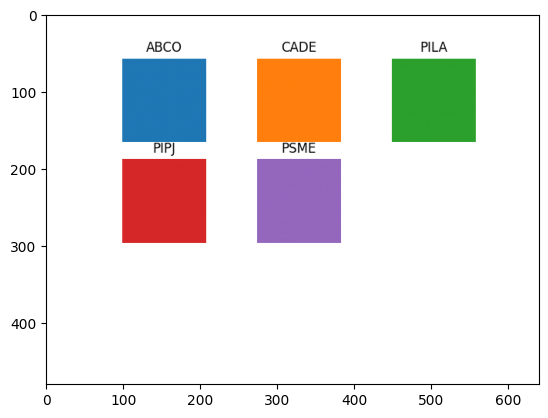

showing /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/vis/train/chips_ChipsB_80m_2021_complete_SD_card_25_103MEDIA_DJI_0935_rgb.JPG


/tmp/ipykernel_3903/4204227826.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imread(file))


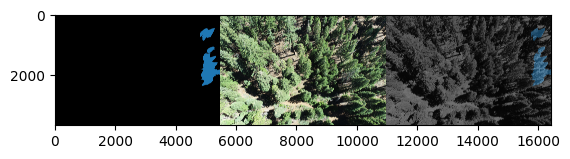

showing /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/vis/train/chips_ChipsB_80m_2021_complete_SD_card_25_104MEDIA_DJI_0107_rgb.JPG


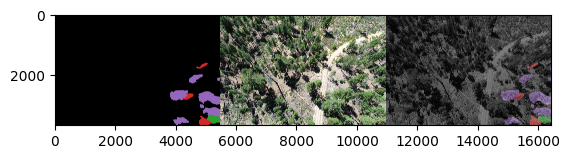

showing /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/vis/val/delta_DeltaB_80m_PART_04_102MEDIA_DJI_0503_rgb.JPG


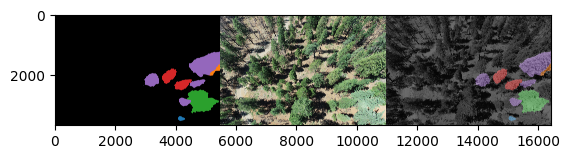

showing /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/vis/val/delta_DeltaB_80m_PART_02_104MEDIA_DJI_0219_rgb.JPG


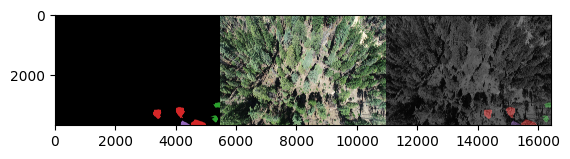

showing /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/vis/val/delta_DeltaB_80m_PART_03_102MEDIA_DJI_0732_rgb.JPG


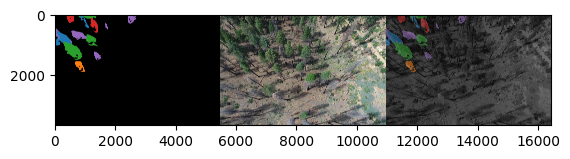

showing /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/vis/train/chips_ChipsB_80m_2021_complete_SD_card_26_100MEDIA_DJI_0484_rgb.JPG


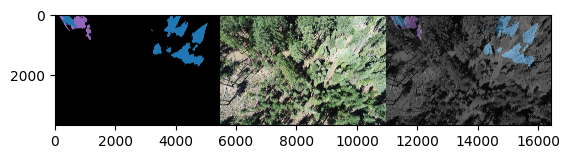

showing /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/vis/train/delta_DeltaB_80m_PART_02_104MEDIA_DJI_0334_rgb.JPG


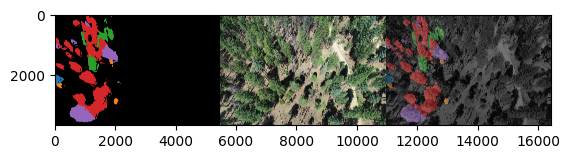

showing /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/vis/train/delta_DeltaB_80m_PART_03_100MEDIA_DJI_0087_rgb.JPG


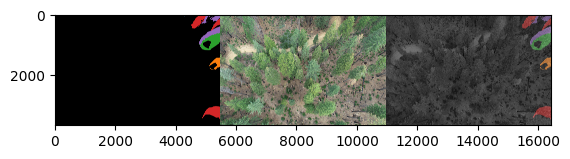

showing /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/vis/train/chips_ChipsB_80m_2021_complete_SD_card_26_100MEDIA_DJI_0891_rgb.JPG


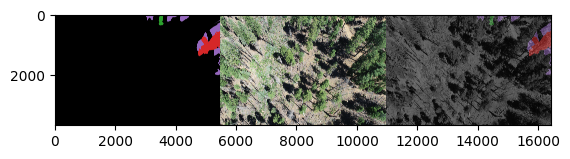

showing /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/vis/train/delta_DeltaB_80m_PART_04_102MEDIA_DJI_0555_rgb.JPG


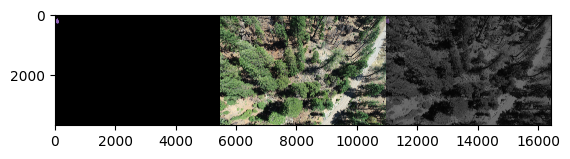

In [5]:
cmap_file = Path(TRAINING_DATA_FOLDER_SCRATCH, "colormap.png")
plt.imshow(imread(cmap_file))
plt.show()

vis_folder = Path(TRAINING_DATA_FOLDER_SCRATCH, "vis")
vis_files = list(vis_folder.rglob("*JPG"))
for file in np.random.choice(vis_files, 10):
    print(f"showing {file}")
    plt.imshow(imread(file))
    plt.show()

# Train a model

In [6]:
WORK_DIR = get_work_dir(training_sites=TRAINING_SITES, is_ortho=False)

# Identify the config file as the only python file in the
config_file = list(Path(TRAINING_DATA_FOLDER_SCRATCH).glob("*py"))[0]
subprocess.run(
    f"{MMSEG_PYTHON} {TRAIN_SCRIPT} {config_file} --work-dir {WORK_DIR}", shell=True
)

02/21 16:54:48 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Mar  2 2023, 03:21:46) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 1075309624
    GPU 0: GRID A100X-20C
    CUDA_HOME: /ofo-share/repos-david/conda/envs/MVMT-stable
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencod

/ofo-share/repos-david/mmsegmentation/mmseg/models/builder.py:42: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn(
/ofo-share/repos-david/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:245: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/ofo-share/repos-david/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:64: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn(


02/21 16:55:04 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.weight:lr=6e-05
02/21 16:55:04 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.weight:weight_decay=0.0
02/21 16:55:04 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.weight:decay_mult=0.0
02/21 16:55:04 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.bias:lr=6e-05
02/21 16:55:04 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.bias:weight_decay=0.0
02/21 16:55:04 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.bias:decay_mult=0.0
02/21 16:55:04 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm1.weight:lr=6e-05
02/21 16:55:04 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm1.weight:weight_decay=0.0
02/21 16:55:04 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm1.weight:decay_mult=0.0
02/21 16:55:04 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm

CompletedProcess(args='/ofo-share/repos-david/conda/envs/openmmlab/bin/python /ofo-share/repos-david/mmsegmentation/tools/train.py /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/MVMT_chips_delta.py --work-dir /home/russelldj/scratch/organized_str_disp_MVMT_experiments/models/multi_site/MVMT_chips_delta/work_dir', returncode=0)